# Setup

## Imports & Settings

In [2]:
%load_ext autoreload
%autoreload 2

import os
import re
import itertools
import functools
import seaborn as sb
import matplotlib.pyplot as plt
import scipy
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import corescpy as cr

# Big Options
overwrite = False  # don't overwrite object
full_object = False  # False = faster; True = more features
# write_object_suffix = None
obj_suffix = "_downstream_reconciled"
panel = "TUQ97N"
capitalize_sample = True if panel == "TUQ97N" else False
# panel = "XR4UZH"
suffix = ""  # if main objects (<sample><_region if applicable>.h5ad)
# suffix = "_new"  # example suffix for object h5ad file (to avoid overwrite)
n_jobs = 20
# drop_cts = ["Epithelial | Lymphoid", "Neuron-Glia | Pericyte"]
drop_cts = []
drop_libs = ["Uninflamed-50403A1"]  # change to None to keep all

# For Regional/Object Sub-Directory Analyses
# sub_dir_parent = None
# sub_dirs = [None]  # if no sub-directory; top level of
sub_dir_parent = "objects_cropped"  # sub-directory: regional (suffix) objects
sub_dirs = ["mucosa", "submucosa", "myenteric_plexus", "smc_circular",
            "smc_longitudinal", "serosa"]  # if objects in sub-directories

# Main Directories
usr_write_rel_path = f"{os.getlogin()}/data/shared-xenium-library"
d_hpc = "/mnt/cho_lab" if os.path.exists(
    "/mnt/cho_lab") else "/sc/arion/projects/untreatedIBD"  # HPC path
d_nfs = os.path.join(d_hpc, "bbdata2") if os.path.exists(os.path.join(
    d_hpc, "bbdata2")) else os.path.join(
        d_hpc, "chobiolab-core/shared-xenium-library")
d_usr = os.path.join(d_hpc, "disk2", usr_write_rel_path) if os.path.exists(
    os.path.join(d_hpc, "disk2")) else os.path.join(d_hpc, usr_write_rel_path)
d_obj = d_usr  # CHANGE IF WRITING & PULLING OBJECTS FROM DIFFERENT PATHS
d_img = os.path.join(d_hpc, f"cache/tissue-registry/xenium/{panel}") if (
    "arion" in d_hpc) else os.path.join(d_hpc, f"bbdata1/xenium/{panel}")

# Construct Directories (Less Likely to Need Changes)
# Mirror my file/directory tree in the `d_usr` directory
obj_ext = ".h5ad"  # extension for processed objects
out_subdir_markers = "find_markers"  # sub-directory under out_dir for markers
out_obj = os.path.join(d_obj, f"outputs/{panel}/nebraska")
out_dir = os.path.join(d_usr, f"outputs/{panel}/nebraska")  # to save objects
out_plot = None if out_dir is None else os.path.join(
    out_dir, "plots/downstream")  # plot output directory
file_mdf = os.path.join(d_usr, f"samples_{panel}.csv")  # metadata file path
file_a = None  # don't map manual annotations
file_a = os.path.join(out_dir, "annotation_dictionaries/annotations_all.xlsx")
print(f"\n\n\n{'=' * 80}\nDirectories\n{'=' * 80}\n\nHPC Entry Point (Cho): "
      f"{d_hpc}\nData: {d_nfs}\nMetadata: {file_mdf}\nImages: {d_img}\n"
      f"Object/Outputs:\n\t{out_dir} (objects)\n\t{out_plot} (plots)\n\t"
      f"{os.path.join(out_dir, out_subdir_markers)} (markers)\n"
      f"Annotations: {file_a}\n\n\n")

# Computing Resources
gpu = False
sc.settings.n_jobs = 8
# sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=200, frameon=False, figsize=(20, 20))
plt.rcParams["axes.labelsize"] = 14    # Axis labels
plt.rcParams["axes.titlesize"] = 20    # Title
plt.rcParams["xtick.labelsize"] = 14   # X-axis tick labels
plt.rcParams["ytick.labelsize"] = 14   # Y-axis tick labels
plt.rcParams["figure.titlesize"] = 20  # Suptitle (overall figure title)

# Samples/Runs
run = None  # just look for samples in all Xenium runs for the panel
# run = "CHO-001"  # run all from this run; so don't have to specify samples
samples = "all"  # use samples = "all" with run = something for all from run
# samples = [  # sample IDs from patients for whom we have all conditions
#     "50452A", "50452B", "50452C",  # old segmentation
#     "50006A", "50006B", "50006C",  # rest are new segmentation
#     "50217A", "50217B", "50217C",
#     "50336B", "50336C", "50336A",
#     "50403A2", "50403B", "50403C1"
# ]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2

# Object Files: Suffixes on Sample ID = Subdirectories or Single Suffix or ""
suffixes = [f"_{x}{suffix}" if x else f"{suffix}" for x in sub_dirs]
suffixes, sub_dirs = [""] + suffixes, [None] + sub_dirs  # to also run overall

# Genes of Interest
genes = {
    "CD Risk": ["LACC1", "LRRK2", "PTGER4"],
    "SnC Marker": ["CDKN2A", "CDKN1A", "TP53", "PLAUR"],
    "Apoptosis-Resistance": ["BCL2"],
    "SASP": ["IL4", "IL13", "IL1A", "CXCL8", "CCL2", "CEBPB", "NFKB1",
             "TGFB1", "IGFBP7"],
    "SASP-IL6": ["OSM", "IL6", "IL6ST"],
    "Fibrosis": ["SUCNR1", "CXCR4", "IL33", "IL23A",
                 "IL1B", "IL12", "IL17", "IL36", "TL1A", "IL11", "IFNG",
                 "IL22", "IL10", "IL21", "IL34", "CCL11"],
    "ER Stress/UPR": ["ATF4"],
    "Autophagy": ["MTOR", "ATG3", "ATG5", "ATG7", "ATG12", "ATG16L1",
                  "SQSTM1", "BECN1", "IRGM1", "ATG8", "ATG6"],
    "DNA Repair": ["ERCC1", "ERCC4"],
    "Healing": ["LCN2", "MMP9", "GREM1", "PDGFRA"],
    "Mixed": ["ICAM1"]
}   # genes of interest
genes_dict_colors = [
    "#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
    "#FFC0CB", "#A52A2A", "#800080", "#008000", "#808080"
] if isinstance(genes, dict) else None  # colors for each "key" of genes_dict

# Leiden Column & Manual Annotation Mapping Options
col_leiden = f"leiden_res1pt5_dist0_npc30"
col_assignment = "lump"  # column in annotation file whose labels to use
col_cluster = col_leiden if file_a is None else str(
    col_assignment + "_" + col_leiden.split("leiden_")[1])
# col_assignment = "annotation"  # more specific cell types
suffix_ct = f"_{col_leiden}" + str(f"_{col_cluster}" if (
    col_cluster != col_leiden) else "")  # new out file suffix ~ cell type

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.




Directories

HPC Entry Point (Cho): /mnt/cho_lab
Data: /mnt/cho_lab/bbdata2
Metadata: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_TUQ97N.csv
Images: /mnt/cho_lab/bbdata1/xenium/TUQ97N
Object/Outputs:
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska (objects)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/plots/downstream (plots)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/find_markers (markers)
Annotations: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/annotations_all.xlsx





## Setup

Get constants (e.g., column names in metadata), read metadata, create dictionary of clustering parameters (so can iterate across different clustering specifications to make multiple versions, e.g., at multiple resolutions) using `res_list`, `min_dist_list`, and `n_comps_list`, make any output directories (e.g., for processed objects, plots, find markers results, Xenium Explorer cluster files) if any don't exist yet, load data into objects, etc.

In [3]:
# Get/Set Constants
constants_dict = cr.get_panel_constants(panel_id=panel)
col_sample_id_o, col_sample_id, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]
key_uninflamed, key_inflamed, key_stricture = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "key_uninflamed", "key_inflamed", "key_stricture"]]
palette = "tab20" if panel != "TUQ97N" else dict(zip([
    key_uninflamed, key_inflamed, key_stricture], ["b", "r", "y"]))
gois = functools.reduce(lambda i, j: i + j, [genes[x] for x in genes])

# Read Metadata
metadata = cr.pp.get_metadata_cho(
    d_nfs, file_mdf, panel_id=panel, samples=samples, run=run,
    capitalize_sample=capitalize_sample)  # get metadata
print("\n\n", metadata[list(set([
    col_sample_id_o, col_subject, col_condition, col_inflamed, col_stricture,
    col_segment]).intersection(metadata))])

# Annotation File
f_ann = pd.read_excel(os.path.join(
    out_dir, "annotation_dictionaries/annotations_all.xlsx"), index_col=[
        0, 1, 2]).dropna(how="all").dropna(how="all", axis=1)
ixs = f_ann.index.names
f_ann = f_ann.reset_index().astype({ixs[2]: "int"}).reset_index()
f_ann.loc[:, ixs[2]] = pd.Categorical(f_ann[ixs[2]].astype("string"))
f_ann = f_ann.set_index(ixs)

# Final Setup
if out_plot is not None:
    os.makedirs(out_plot, exist_ok=True)  # ensure plot save path exists
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cluster)



                    stricture inflammation   Condition sample_id  subject_id
Sample                                                                     
Uninflamed-50403A2        no   uninflamed  uninflamed   50403A2       50403
Uninflamed-50403A1        no   uninflamed  uninflamed   50403A1       50403
Uninflamed-50336C         no   uninflamed  uninflamed    50336C       50336
Inflamed-50336B           no     inflamed    inflamed    50336B       50336
Stricture-50336A         yes     inflamed   stricture    50336A       50336
Stricture-50403C2        yes     inflamed   stricture   50403C2       50403
Stricture-50403C1        yes     inflamed   stricture   50403C1       50403
Inflamed-50403B           no     inflamed    inflamed    50403B       50403
Stricture-50217C         yes     inflamed   stricture    50217C       50217
Uninflamed-50217B         no   uninflamed  uninflamed    50217B       50217
Inflamed-50217A           no     inflamed    inflamed    50217A       50217
Stricture

# Describe

Number of cells per region.

In [ ]:
n_cells = {}
for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    out_r = str(os.path.join(out_plot, sub_d) if (
        sub_d) else out_plot) if out_plot else None  # plot directory
    in_r = os.path.join(out_obj, sub_dir_parent) if (
        sub_dir_parent) else out_obj  # object directory
    in_r = os.path.join(in_r, sub_d) if sub_d else in_r  # sub-directory?
    n_cells[r] = {}

    # Iterate Samples
    for x in metadata.index.values:
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        out = os.path.join(in_r, f"{x}{r}{obj_ext}")
        if not os.path.exists(out):
            print(f"Skipping {x}: {out} doesn't exist!")
            n_cells[r][x] = np.nan
        else:
            n_cells[r][x] = sc.read_h5ad(out).obs.shape[0]

# Analyze

The first clustering version (first specified in `res_list`) is the cell type column used by default in downstream analyses (because it was specified in `kws_init["col_cell_type"]` when creating the object and thus is stored in `self._columns["col_cell_type"]`). Specify `col_cell_type` as an argument in the following functions to use a different column.



Uninflamed-50403A2




Input Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50403A2.h5ad
Output Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50403A2_downstream_reconciled.h5ad
Plot Directory: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/plots/downstream


<<< INITIALIZING SPATIAL CLASS OBJECT >>>



Counts: Initial: table


	Observations: 202062

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%             5431.0     0.031646           0.031156              82.204565   
50%            17544.0     0.112692           0.106782              91.751569   
75%            37850.0     0.262282           0.232921              97.446578   

     total_counts  log1p_total_counts  n_cells  n_counts     means  \
25%        6731.0            8.814628   5337.0    6708.0  1.414975   
50%       23969.0           10

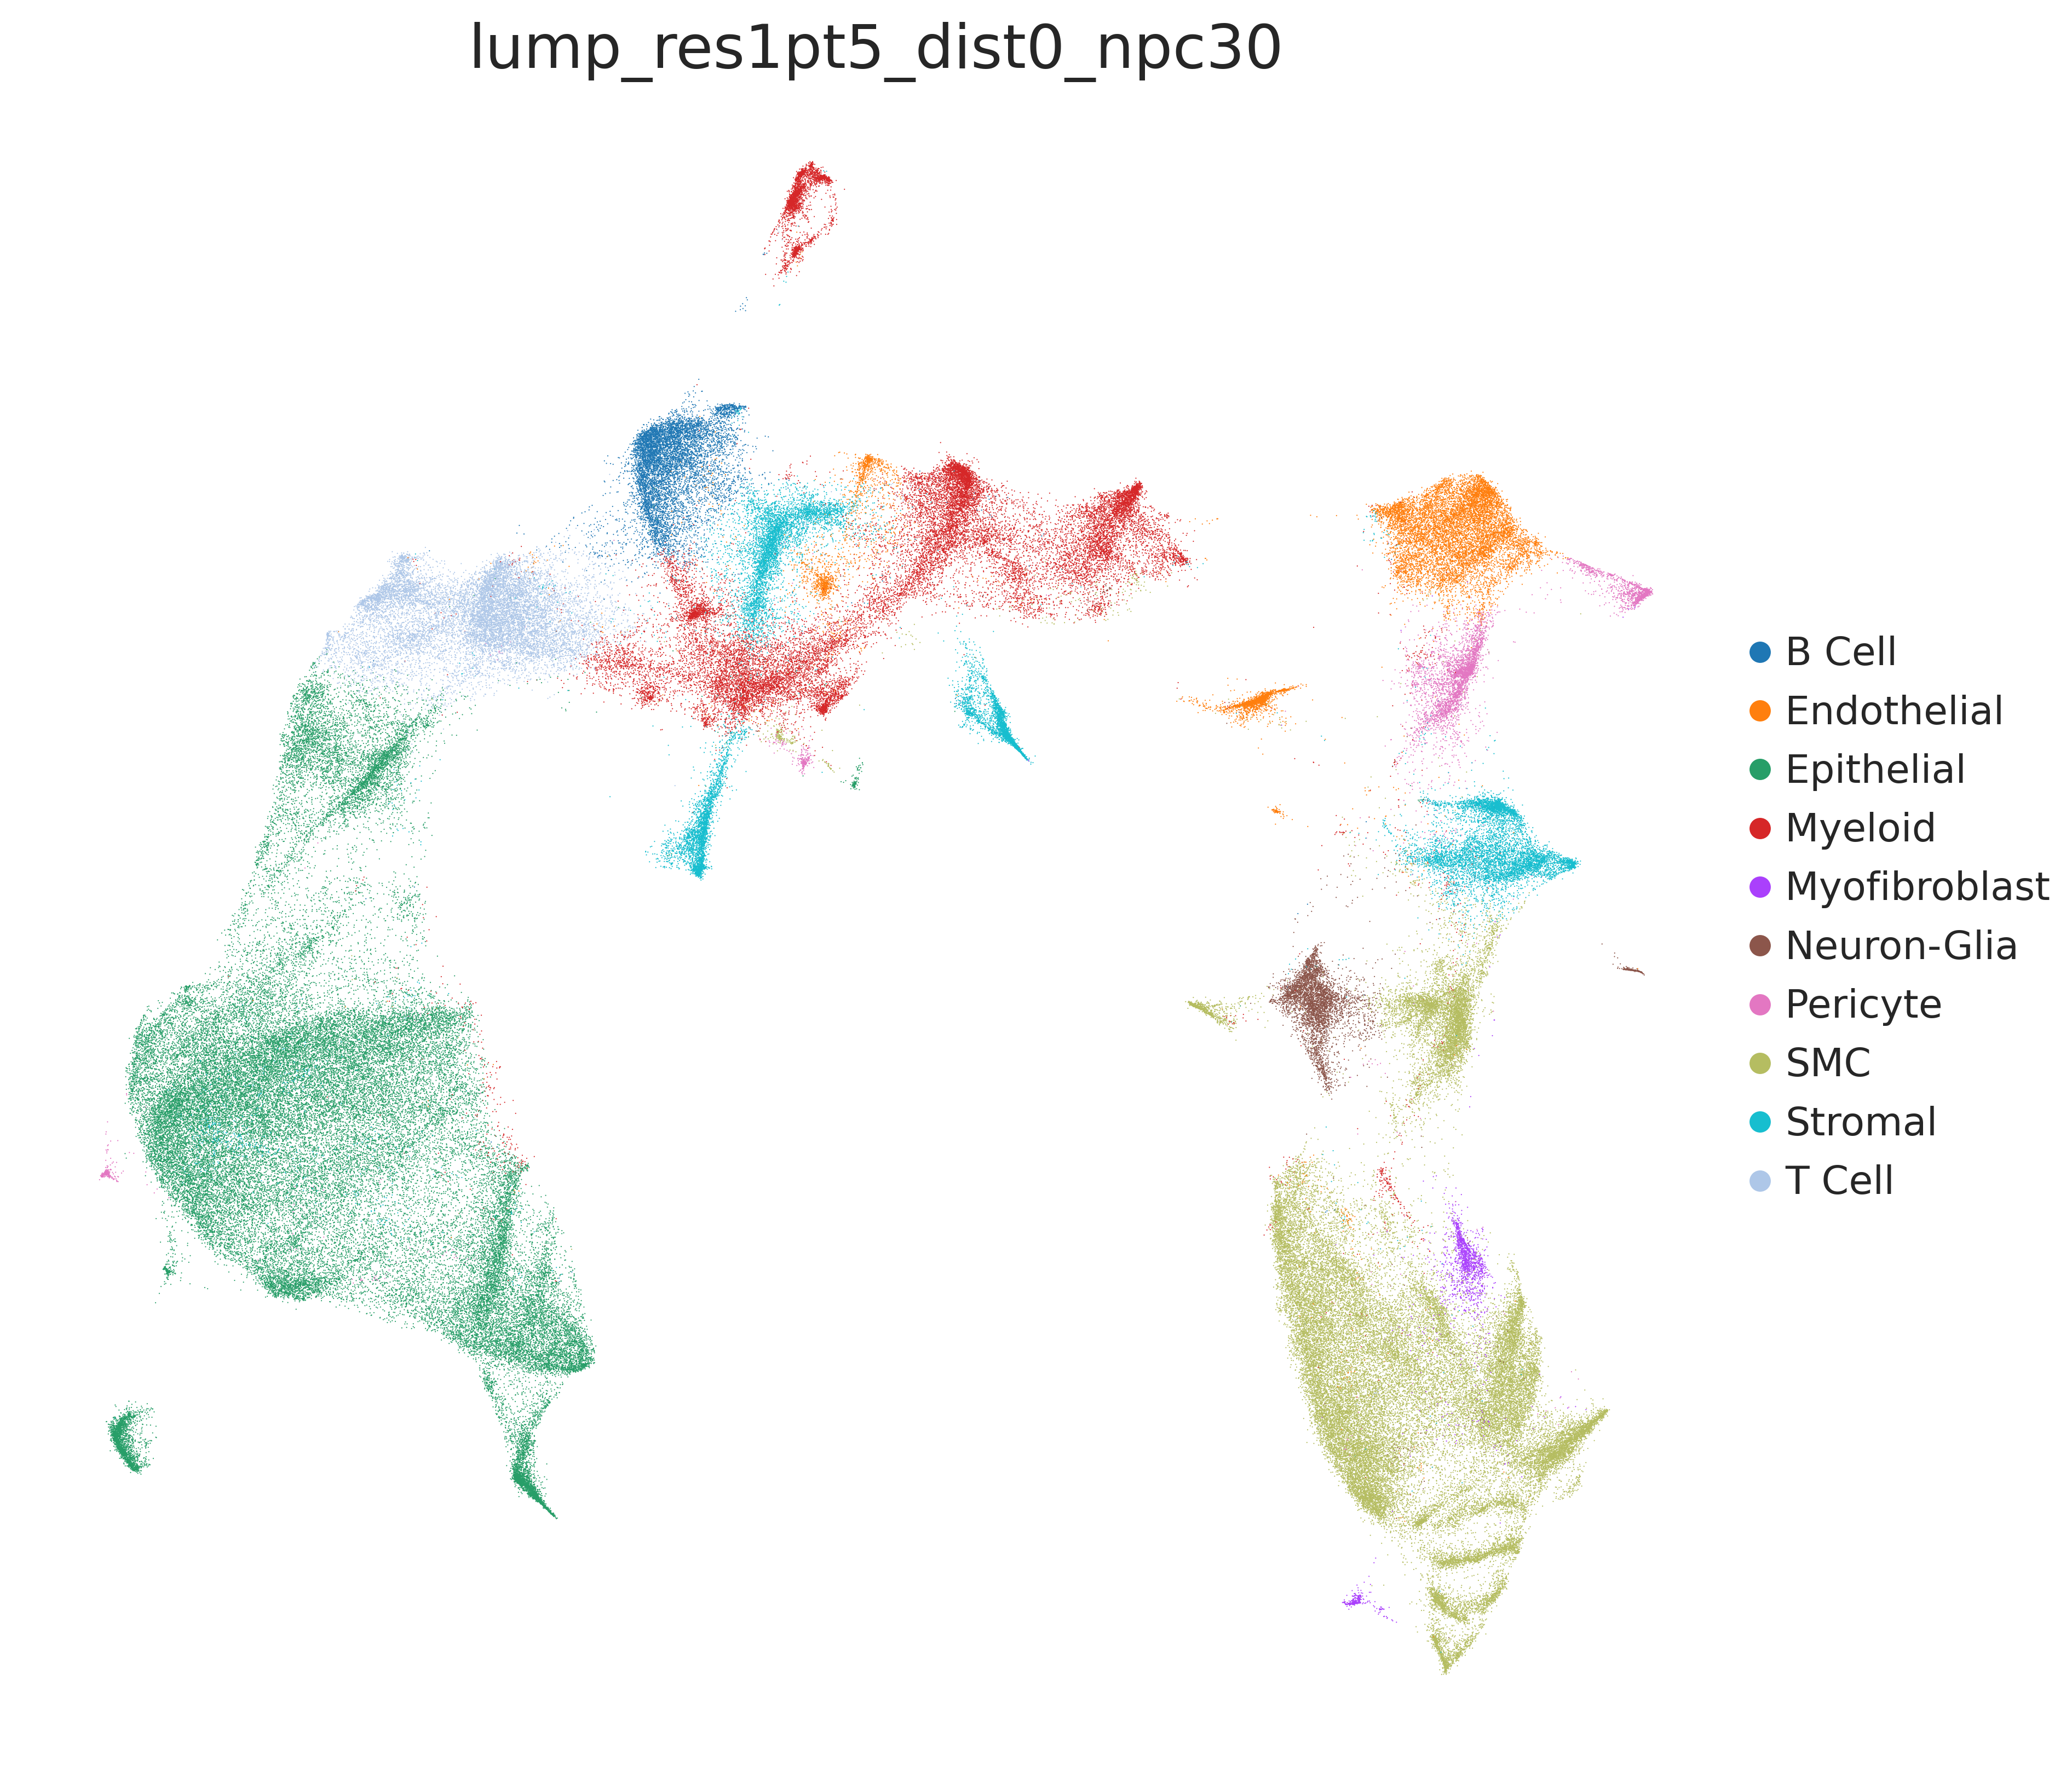



<<< QUANTIFYING GRAPH >>>


	*** Building connectivity matrix...
	*** Computing & plotting centrality scores...
ERROR: Unable to fetch palette, reason: 'lump_res1pt5_dist0_npc30_colors'. Using `None`.

	*** Computing interaction matrix...


*** Centrality scores stored in `.rna.uns['lump_res1pt5_dist0_npc30_centrality_scores']`




*** Interaction matrix results stored in `.rna.uns['lump_res1pt5_dist0_npc30__interactions']`




<<< QUANTIFYING NEIGHBORHOOD ENRICHMENT (zscore) >>>




  0%|          | 0/1000 [00:00<?, ?/s]



*** Neighborhood results stored in `.rna.uns['lump_res1pt5_dist0_npc30_nhood_enrichment']`




<<< QUANTIFYING CO-OCCURRENCE >>>




  0%|          | 0/4950 [00:00<?, ?/s]

In [5]:
%%time

# Iterate Regions
for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    fig_central, fig_neigh, fig_cooccur, fig_svg = {}, {}, {}, {}
    fig_gex = {"heat": {}, "dot": {}}
    if (r == "" and sub_d == "") or sub_d is None:
        in_r = out_obj
        out_r = out_plot
    else:
        in_r = os.path.join(out_obj, sub_dir_parent) if (
            sub_dir_parent) else out_obj  # object directory
        in_r = os.path.join(in_r, sub_d) if sub_d else in_r  # sub-directory?
        out_r = str(os.path.join(out_plot, sub_d) if (
            sub_d) else out_plot) if out_plot else None  # plot directory
    if out_plot is not None:
        os.makedirs(out_r, exist_ok=True)
    if obj_suffix is not None:  # new object directory
        out_obj_new = os.path.join(out_dir, sub_dir_parent) if (
            sub_dir_parent) and (r != "" and sub_d != "") else out_dir
        os.makedirs(out_obj_new, exist_ok=True)

    # Iterate Samples
    for x in metadata.index.values:
        if drop_libs is not None and x in drop_libs:
            continue
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")

        # Load Data
        out = os.path.join(in_r, f"{x}{r}{obj_ext}")
        out_h5ad = os.path.join(out_obj_new, sub_d if sub_d else "",
                                f"{x}{r}{obj_suffix}.h5ad")
        print(f"\n\nInput Object: {out}\nOutput Object: {out_h5ad}\n"
              f"Plot Directory: {out_r}")
        if not os.path.exists(out):
            print(f"Skipping {x}: {out} doesn't exist!")
            continue
        if overwrite is False and os.path.exists(out_h5ad):
            print(f"\n\nAlready exists: {out_h5ad}\n\n")
            continue
        self = cr.Spatial(metadata.loc[x][col_f] if full_object else out,
                          path_xenium=metadata.loc[x][col_f],
                          library_id=x, **kws_init)
        if full_object is True:
            self.update_from_h5ad(out)  # update with prior preprocessing
        # for j in metadata.dropna(how="all", axis=1):  # add metadata to .obs
        #     self.rna.obs.loc[:, j] = str(metadata.loc[x][j])
        _ = self.annotate_clusters(
            f_ann.loc[self._library_id].loc[col_leiden][col_assignment],
            col_cell_type=col_leiden, col_annotation=col_cluster,
            copy=False)  # annotations

        # Gene Expression Plots (Only GEX Data)
        goi = list(set(pd.unique(functools.reduce(lambda u, v: u + v, [
            genes[g] for g in genes])) if isinstance(genes, dict) else genes
                    ).intersection(self.rna.var_names))  # gene list
        # fig_gex["spatial"][self._library_id] = self.plot_spatial(
        #     color=goi + [col_cluster], title=f"{self._library_id}{r}")
        pex = "_".join(re.sub("/", "", str(
            f"{self._library_id}{r}{suffix_ct}_{'_'.join(genes)}")).split(
                " ")) + ".jpeg"
        fig_gex["dot"][self._library_id] = cr.pl.plot_dot(
            self.rna, col_cluster, genes,
            title=f"{self._library_id}{r}",
            genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
            percent="right", center=None, out_file=os.path.join(
                out_r, "dot_gex_" + pex))
        fig_gex["heat"][self._library_id] = cr.pl.plot_matrix(
            self.rna, col_cluster, genes,
            title=f"{self._library_id}{r}",
            genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
            percent="right", center=None, out_file=os.path.join(
                out_r, "heat_gex_" + pex))

        # Spatial Analyses
        _, fig_central[self._library_id] = self.calculate_centrality(
            figsize=(20, 10), n_jobs=n_jobs, out_plot=os.path.join(
                out_r, f"centrality_{self._library_id}{r}{suffix_ct}.jpeg"))
        _, fig_neigh[self._library_id] = self.calculate_neighborhood(
            figsize=(60, 30),  # n_jobs=n_jobs
            out_plot=os.path.join(
                out_r, f"neighborhood_{self._library_id}{r}{suffix_ct}.jpeg"))
        _, fig_cooccur[self._library_id] = self.find_cooccurrence(
            figsize=(60, 20), n_jobs=n_jobs,
            kws_plot=dict(wspace=3), out_plot=os.path.join(
                out_r, f"cooccurrence_{self._library_id}{r}{suffix_ct}.jpeg"))
        _ = self.find_svgs(
            genes=goi, method="moran", n_perms=10, kws_plot=dict(
                legend_fontsize="large"), figsize=(15, 15), n_jobs=n_jobs,
            title=self._library_id,
            out_plot=os.path.join(
                out_r, f"svg_{self._library_id}{r}{suffix_ct}.jpeg"))
        if out_h5ad is not None:
            print(f"Writing {out_h5ad}")
            self.write(out_h5ad)

# Reload & Concatenate Results

In [ ]:
%%time

# Iterate Regions
cells_spatial, genes_spatial, cooccur = {}, {}, {}
for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    rix = "Overall" if sub_d in [None, ""] else sub_d
    outed = os.path.join(out_dir, sub_dir_parent) if (
        sub_dir_parent) and sub_d is not None else out_dir  # object directory
    cells_spatial[rix], genes_spatial[rix], cooccur[rix] = {}, {}, {}

    # Iterate Samples
    for x in metadata.index.values:
        print(f"\n\n{'=' * 80}\n{rix}: {x}\n{'=' * 80}\n\n")
        out_h5ad = os.path.join(outed, sub_d if sub_d else "",
                                f"{x}{r}{obj_suffix}.h5ad")
        if drop_libs is not None and x in drop_libs:
            continue
        if not os.path.exists(out_h5ad):
            print(f"{out_h5ad} doesn't exist!")
            continue
        self = cr.Spatial(out_h5ad, path_xenium=metadata.loc[x][col_f],
                          library_id=x, **kws_init)
        if not os.path.exists(out_h5ad):
            print(f"{out_h5ad} doesn't exist!")
            continue
        k_c = f"{self._columns['col_cell_type']}_centrality_scores"
        if k_c not in self.rna.uns:
            print(f"Spatial results {k_c} missing from `self.rna.uns`!")
            continue
        central = self.rna.uns[k_c].rename_axis(
            self._columns["col_cell_type"])
        cccs = central.index.values
        k_n = f"{self._columns['col_cell_type']}_nhood_enrichment"
        neigh = pd.concat([pd.DataFrame(
            self.rna.uns[k_n][q], index=cccs, columns=cccs).rename_axis(
                self._columns["col_cell_type"]).rename_axis(
                    f"{self._columns['col_cell_type']}_2", axis=1).stack()
                for q in self.rna.uns[k_n]], keys=self.rna.uns[k_n], axis=1)
        neigh.columns = [f"neighborhood_{q}" for q in neigh.columns]
        ixs = pd.DataFrame(
            self.rna.uns[f"{self._columns['col_cell_type']}_interactions"],
            index=cccs, columns=cccs).rename_axis(self._columns[
                "col_cell_type"]).rename_axis(
                    f"{self._columns['col_cell_type']}_2", axis=1)
        k_cooc = f"{self._columns['col_cell_type']}_co_occurrence"
        if k_cooc in self.rna.uns:
            cooc = self.rna.uns[k_cooc]
            cooc = pd.concat([pd.DataFrame(cooc["occ"][:, :, i], pd.Index(
                cccs, name=self._columns["col_cell_type"]), columns=pd.Index(
                    cccs, name=f"{self._columns['col_cell_type']}_2"))
                              for i in np.arange(cooc["occ"].shape[2])],
                             keys=cooc["interval"], names=["Interval"])
            cooccur[rix][x] = cooc
        cells_spatial[rix][x] = central.join(ixs.stack().to_frame(
            "Interaction Score").join(neigh))
        if "moranI" in self.rna.uns:
            svg = self.rna.uns["moranI"].rename_axis(
                "Gene").rename_axis("Metric", axis=1)
            svg.columns = [f"svg_{q}" for q in svg.columns]
            genes_spatial[rix][x] = svg
    cells_spatial[rix], genes_spatial[rix], cooccur[rix] = [
        pd.concat([v[j] for j in v], keys=v, names=[
            self._columns["col_sample_id"]]) if len(v) > 0 else None
        for v in [cells_spatial[rix], genes_spatial[rix], cooccur[rix]]]
cells_spatial, genes_spatial, cooccur = [pd.concat([
    u[r] for r in u], keys=u, names=["Region"]) for u in [
        cells_spatial, genes_spatial, cooccur]]
cells_spatial, genes_spatial, cooccur = [x.join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True)
    for x in [cells_spatial, genes_spatial, cooccur]]
cells_spatial, genes_spatial, cooccur = [x.reset_index().set_index([
    "Region", col_subject, col_condition] + list(x.index.names.difference([
        "Region", col_subject, col_condition]))) for x in [
            cells_spatial, genes_spatial, cooccur]]
cooccur = cooccur.rename_axis(f"{col_cluster}_2", axis=1)
# cells_spatial = cells_spatial.rename({
#     "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"
#     }, level=col_cluster).rename({
#         "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"},
#                                  level=f"{col_cluster}_2")
# cooccur = cooccur.rename({
#     "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"}, axis=1).rename({
#         "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"})
print(cooccur)
print(genes_spatial)
print("\n\n\n\nCells Results:\n\n", cells_spatial.reset_index().groupby([
    "Region", col_condition]).apply(lambda x: x.subject_id.unique()))
print("\n\n\n\nGenes Results:\n\n", genes_spatial.reset_index().groupby([
    "Region", col_condition]).apply(lambda x: x.subject_id.unique()))
cells_spatial

## Normalize

In [ ]:
col_nb = "Neighborhood Score (Maximum-Normalized)"
cells_spatial = cells_spatial.join(cells_spatial.groupby([
    "Region", col_sample_id]).apply(
        lambda x: x["neighborhood_count"] / max(x["neighborhood_count"]),
        include_groups=False).reset_index([0, 1], drop=True).to_frame(col_nb))

# Visualize

## SVGs

In [ ]:
p_threshold, n_top = 0.05, 10
svgs_i = genes_spatial[genes_spatial["svg_pval_norm"] < p_threshold]
svgs_i = svgs_i.groupby(["Region", col_condition]).apply(
    lambda x: x.sort_values("svg_I").iloc[:n_top]).reset_index(
        [0, 1], drop=True)
gsvg = svgs_i.loc["Overall"].sort_index().reset_index().Gene.unique()
sb.catplot(genes_spatial[genes_spatial["svg_pval_norm"] < p_threshold].loc[
    :, :, :, :, gsvg].loc["Overall"], hue=col_condition, x="Gene",
           y="svg_I", kind="bar", palette=palette, hue_order=list(
               palette.keys()) if isinstance(palette, dict) else None,
           height=12, aspect=2.5)
sb.catplot(genes_spatial[genes_spatial["svg_pval_norm"] < p_threshold].loc[
    :, :, :, :, gsvg].loc["Overall"], hue=col_condition, x="Gene",
           y="svg_I", kind="bar", palette=palette, hue_order=list(
               palette.keys()) if isinstance(palette, dict) else None,
           col=col_subject, col_wrap=3, height=12, aspect=2.5)
sb.catplot(genes_spatial[genes_spatial["svg_pval_norm"] < p_threshold].loc[
    :, :, :, :, gsvg], hue=col_condition, x="Gene",
           y="svg_I", kind="bar", palette=palette, hue_order=list(
               palette.keys()) if isinstance(palette, dict) else None,
           col="Region", col_wrap=3, height=12, aspect=2.5)

## Co-Occurrence

In [ ]:
    iv = 50
    cooccur_interval = cooccur.drop(drop_cts, axis=1).drop(
        drop_cts, level=col_cluster).reset_index("Interval").groupby([
            "Region", col_sample_id, col_cluster]).apply(
                lambda x: x.iloc[np.argmin(abs(x["Interval"] - iv))]).drop(
                    "Interval", axis=1).stack().to_frame("Pr(Co-Occur)").join(
                        metadata[[col_subject, col_condition]])
    if "Overall" in cooccur_interval.reset_index()["Region"].to_list():
        cooccur_interval
        fig = sb.catplot(cooccur_interval.loc["Overall"], x=col_cluster,
                         y="Pr(Co-Occur)", hue=col_condition, kind="bar",
                         col=f"{col_cluster}_2", col_wrap=4,
                         # aspect=2.5,
                         palette=palette, height=15)
        fig.set_xticklabels(rotation=45, fontsize=12)
        fig.set_titles(col_template="{col_name}", size=16)
        fig.fig.suptitle(
            f"Co-Occurrence Probability (Interval = {iv:.2g})", fontsize=18)
        fig.fig.tight_layout()
        plt.subplots_adjust(hspace=1, top=0.92, right=0.85)
        fig.fig.set_dpi(200)

In [ ]:
ref = "Myeloid"

fig = sb.displot(cooccur.reset_index("Interval"), x="Interval", kind="kde",
                 cut=0, fill=True, hue="Region")
fig.fig.suptitle("Co-Occurrence Computed Interval Distributions by Region")
fig.fig.tight_layout()

fig = sb.displot(cooccur.reset_index("Interval"), x="Interval", kind="kde",
                 cut=0, fill=True, hue=col_subject)
fig.fig.suptitle("Co-Occurrence Computed Intervals by Patient")
fig.fig.tight_layout()

print(cooccur.reset_index("Interval")["Interval"].groupby([
    "Region"]).describe())

intervals = [50, cooccur.reset_index("Interval")[
        "Interval"].groupby(["Region"]).describe()["75%"].median()]
for iv in intervals:
    cooccur_interval = cooccur.drop(drop_cts, axis=1).drop(
        drop_cts, level=col_cluster).reset_index("Interval").groupby([
            "Region", col_sample_id, col_cluster]).apply(
                lambda x: x.iloc[np.argmin(abs(x["Interval"] - iv))]).drop(
                    "Interval", axis=1).stack().to_frame("Pr(Co-Occur)").join(
                        metadata[[col_subject, col_condition]])
    if "Overall" in cooccur_interval.reset_index()["Region"].to_list():
        cooccur_interval
        fig = sb.catplot(cooccur_interval.loc["Overall"], x=col_cluster,
                         y="Pr(Co-Occur)", hue=col_condition, kind="bar",
                         col=f"{col_cluster}_2", col_wrap=4,
                         aspect=2.5, palette=palette)
        fig.set_xticklabels(rotation=45, fontsize=12)
        fig.set_titles(col_template="{col_name}", size=16)
        fig.fig.suptitle(
            f"Co-Occurrence Probability (Interval = {iv:.2g})", fontsize=18)
        fig.fig.tight_layout()
        plt.subplots_adjust(hspace=1, top=0.92, right=0.85)
        fig.fig.set_dpi(200)
        cooccur_interval = cooccur_interval.drop("Overall", level="Region")
    cooccur_interval = cooccur_interval.loc[:, :, :, ref, :]
    fig = sb.catplot(cooccur_interval, x=col_cluster, y="Pr(Co-Occur)",
                     hue=col_condition, col="Region", col_wrap=3, kind="bar",
                     aspect=2.5, palette=palette)
    fig.set_xticklabels(rotation=45, fontsize=20)
    fig.set_titles(col_template="{col_name}", size=24)
    fig.fig.suptitle(
        f"Probability of {ref} Co-Occurrence (Interval = {iv:.2g})",
        fontsize=32)
    plt.subplots_adjust(hspace=1, top=0.85)
    fig.fig.set_dpi(200)

In [ ]:
# cell_types = list(cooccur.columns)
cell_types = ["Epithelial", "Epithelial (Stem/TA/Paneth)", "Endothelial",
              "Stromal", "Neuron-Glia", "T Cell", "B Cell"]
# cell_refs = cell_types
# cell_refs = ["Neuron-Glia"]
# cell_refs = ["Mast Cell", "Myeloid"]
cell_refs = ["Myeloid"]
regions = cooccur.reset_index()["Region"].unique()
# regions = ["Overall"]
regions = ["mucosa", "submucosa",
           ["smc_circular", "smc_longitudinal", "myenteric_plexus"]]
# regions = ["Overall" if x is None else x for x in sub_dirs]

for ref in cell_refs:
    for r in regions:
        rix = [r] if isinstance(r, str) else r
        ccts = list(set(cell_types).intersection(cooccur.columns))
        coo = cooccur[ccts].loc[rix].stack().unstack(col_cluster)[
            ref].to_frame("Pr(Co-Occur)").reset_index().rename(
                {f"{col_cluster}_2": "Cell Type"}, axis=1)
        fig, axes = plt.subplots(1, len(coo[col_condition].unique()),
                                 sharey=True)
        for i, cond in enumerate(coo[col_condition].unique()):
            sb.lineplot(coo[coo[col_condition] == cond], x="Interval",
                        y="Pr(Co-Occur)", units=col_subject,
                        style=col_subject,
                        hue="Cell Type", estimator=None, ax=axes[i])
            axes[i].set_title(cond)
        reg = f"{' '.join(r.split('_')).capitalize()}" if isinstance(
            r, str) else " | ".join(r)
        fig.suptitle(f"P(Co-Occur) with {ref}: {reg}")
        plt.subplots_adjust(hspace=0.5, top=0.9, right=0.8)

In [ ]:
# cell_types = list(cooccur.columns)
cell_types = ["Endothelial", "Stromal", "Neuron-Glia", "T Cell", "B Cell"]
# cell_refs = cell_types
# cell_refs = ["Neuron-Glia"]
# cell_refs = ["Mast Cell", "Myeloid"]
cell_refs = ["Myeloid"]
regions = cooccur.reset_index()["Region"].unique()
# regions = ["Overall"]
regions = ["mucosa", "submucosa",
           ["smc_circular", "smc_longitudinal", "myenteric_plexus"]]
regions = sub_dirs

for ref in cell_refs:
    for r in regions:
        rix = [r] if isinstance(r, str) else r
        coo = cooccur[cell_types].loc[rix].stack().unstack(col_cluster)[
            ref].to_frame("Pr(Co-Occur)").reset_index().rename(
                {f"{col_cluster}_2": "Cell Type"}, axis=1)
        fig = sb.lmplot(coo, x="Interval", y="Pr(Co-Occur)", lowess=True,
                        col="Cell Type", sharex=False, units=col_subject,
                        sharey=False, hue=col_condition, palette=palette)
        fig.set_titles(col_template="{col_name}", size=24)
        reg = f"{' '.join(r.split('_')).capitalize()}" if isinstance(
            r, str) else " | ".join(r)
        fig.fig.suptitle(f"P(Co-Occur) with {ref}: {reg}")
        plt.subplots_adjust(hspace=0.5, top=0.9, right=0.1)

In [ ]:
# cell_types = list(cooccur.columns)
cell_types = ["Endothelial", "Stromal", "Neuron-Glia"]
# cell_refs = cell_types
# cell_refs = ["Neuron-Glia"]
# cell_refs = ["Mast Cell", "Myeloid"]
cell_refs = ["Myeloid"]
regions = sub_dirs
# regions = cooccur.reset_index()["Region"].unique()
# regions = ["Overall"]
# regions = ["mucosa", "submucosa",
#            ["smc_circular", "smc_longitudinal", "myenteric_plexus"]]

for ref in cell_refs:
    for r in regions:
        rix = ["Overall"] if sub_dirs in [None, ""] else [
            r] if isinstance(r, str) else r
        coo = cooccur[cell_types].loc[rix].stack().unstack(col_cluster)[
            ref].to_frame("Pr(Co-Occur)").reset_index().rename(
                {f"{col_cluster}_2": "Cell Type"}, axis=1)
        fig = sb.lmplot(coo, x="Interval", y="Pr(Co-Occur)", lowess=True,
                        row=col_subject, col="Cell Type", sharex=True,
                        sharey=False, hue=col_condition, palette=palette)
        fig.set_titles(col_template="{col_name}",
                       row_template="{row_name}", size=24)
        reg =  " | ".join([f"{' '.join(u.split('_')).capitalize()}"
                           for u in rix])
        fig.fig.suptitle(f"P(Co-Occur) with {ref}: {reg}")
        fig.fig.tight_layout()
        plt.subplots_adjust(hspace=0.5, top=0.92)

In [ ]:
# # for cell in cooccur.reset_index()[col_cluster].unique():
# for cell in ["Neuron-Glia"]:
#     for r in cooccur.reset_index()["Region"].unique():
#         conds = cooccur.reset_index()[col_condition].unique()
#         fig, axes = plt.subplots(
#             len(cooccur.reset_index()[col_subject]), len(conds))
#         coor = cooccur[cell].to_frame("Pr(Co-Occur)").loc[r].reset_index()
#         for i, x in enumerate(coor[col_subject].unique()):
#             coo = coor[coor[col_subject] == x]
#             for j, y in conds:
#                 sb.lineplot(coo[coo[col_condition] == y], x="Interval",
#                             y="Pr(Co-Occur)", hue=col_cluster,
#                             ax=axes[i, j])
#                 axes[i, j].set_title(f"{y} | {x}")
#         fig.suptitle(f"P(Co-Occur) with {cell}: {r.capitalize()}")

## Neighborhood

In [ ]:
# Only works with one sample per condition; otherwise, modify
measure = "neighborhood_zscore"
# measure = col_nb
for r, sub_d in zip(suffixes, sub_dirs):
    rix = "Overall" if sub_d in [None, ""] else sub_d
    samps = cells_spatial.loc[rix].reset_index()[col_sample_id].unique()
    outed = os.path.join(out_dir, sub_dir_parent) if (
        sub_dir_parent) and sub_d is not None else out_dir
    conds = cells_spatial.loc[rix].reset_index()[col_condition].unique()
    subjs = cells_spatial.loc[rix].reset_index()[col_subject].unique()
    cnb = cells_spatial[measure].loc[rix].unstack(col_cluster).stack(
        dropna=False).unstack(f"{col_cluster}_2")
    fig, axes = plt.subplots(len(conds), len(subjs), dpi=200,
                             figsize=(30, 20), sharex=True, sharey=True)
    for i, g in enumerate(conds):
        for j, s in enumerate(subjs):
            lib = metadata[(metadata[col_subject] == s) & (metadata[
                col_condition] == g)].index.intersection(
                    set(samps)).values[0]
            sb.heatmap(cnb.loc[s].loc[g].loc[lib], ax=axes[i, j],
                       cmap="coolwarm", center=0, cbar=False,
                       # vmin=cnb.describe().loc["25%"].min(),
                       # vmax=cnb.describe().loc["75%"].max(),
                       robust=True,
                       linecolor="none", linewidths=0)
            axes[i, j].set_title(f"{s} {g.capitalize()}", fontsize=18)
    fig.suptitle(rix, fontsize=28)
    fig.supylabel(None)
    for ax in axes.flat:
        ax.set_ylabel("")
        ax.set_xlabel("")
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.1)

In [ ]:
# # Only works with one sample per condition; otherwise, modify
# for r, sub_d in zip(suffixes, sub_dirs):
#     rix = "Overall" if sub_d in [None, ""] else sub_d
#     samps = cells_spatial.loc[rix].reset_index()[col_sample_id].unique()
#     outed = os.path.join(out_dir, sub_dir_parent) if (
#         sub_dir_parent) and sub_d is not None else out_dir
#     conds = cells_spatial.loc[rix].reset_index()[col_condition].unique()
#     subjs = cells_spatial.loc[rix].reset_index()[col_subject].unique()
#     fig, axes = plt.subplots(len(conds), len(subjs),
#                              sharex=True, sharey=True)
#     for i, g in enumerate(conds):
#         for j, s in enumerate(subjs):
#             lib = metadata[(metadata[col_subject] == s) & (metadata[
#                 col_condition] == g)].index.intersection(
#                     set(samps)).values[0]
#             adata = sc.read_h5ad(os.path.join(outed, sub_d if sub_d else "",
#                                               f"{lib}{r}{obj_suffix}.h5ad"))
#             sq.pl.nhood_enrichment(adata, cluster_key=col_cluster, fig=fig,
#                                    mode="zscore", cmap="coolwarm",
#                                    vcenter=0,
#                                    ax=axes[i, j], title=f"{s} {g} {sub_d}")
#     # fig.tight_layout()
#     fig.supylabel(None)
#     plt.subplots_adjust(wspace=4, hspace=0)

In [ ]:
# for x in cells_spatial.columns:
for x in [col_nb]:
    fig = sb.catplot(cells_spatial,
                     # cells_spatial.drop("Overall", level="Region"),
                     x=col_cluster, y=x, hue=col_condition,
                     palette=palette, col="Region", col_wrap=4,
                     sharex=False, kind="bar", height=12, aspect=2.5)
    fig.set_xticklabels(rotation=45, fontsize=20)
    # fig.set_axis_labels(rotation=45, fontsize=36)
    fig.set_titles(fontsize=36)
    fig.fig.suptitle(x)
    plt.subplots_adjust(hspace=0.5, top=0.92)
    # fig.fig.set_dpi(300)
    # fig._legend.set_title(fig._legend.get_title().get_text(), prop={
    #     "size": 16})
    # for text in fig._legend.get_texts():
    #     text.set_fontsize(16)

In [ ]:
# for x in cells_spatial.columns:
for x in [col_nb]:
    fig = sb.catplot(cells_spatial,
                     # cells_spatial.drop("Overall", level="Region"),
                     x=col_cluster, y=x, hue=col_condition, split=True,
                     palette=palette, col="Region", col_wrap=3,
                     sharex=False, kind="violin", height=12, aspect=2.5)
    fig.set_xticklabels(rotation=45, fontsize=20)
    fig.set_titles(fontsize=36)
    fig.fig.suptitle(x)
    plt.subplots_adjust(hspace=0.5, top=0.92)

# Workspace

In [ ]:
cells_spatial

In [ ]:
c_graph = ["degree_centrality", "average_clustering", "closeness_centrality"]
graph = cells_spatial.groupby(cells_spatial.index.names.difference([
    col_cluster + "_2"])).apply(lambda x: x[c_graph].apply(
        lambda y: list(y.unique()))).reset_index(-1, drop=True)
graph_norm = graph / graph.groupby(
    graph.index.names.difference([col_cluster])).max()

In [ ]:
x_order = ["50336", "50403", "50217", "50006"]
x_order = dict(zip([int(x) for x in x_order], x_order))
graph_norm = graph_norm.reset_index()
if x_order:
    graph_norm = graph_norm.assign(subject_id=pd.Categorical(graph_norm.loc[
        :, "subject_id"].replace(x_order).astype(
            "string"), categories=[x_order[x] for x in x_order]))
graph_norm = graph_norm.set_index(graph.index.names)

In [ ]:
graph_norm

In [ ]:
x = "average_clustering"

cts = ["Mast Cell", "Myeloid", "Neuron-Glia", "Endothelial", "Myocytic"]
fig = sb.catplot(graph.loc[:, :, :, :, cts].rename({
    "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"}, level=col_cluster),
                 x=col_cluster, y=x, hue=col_condition, sharex=False,
                 col=col_subject, row="Region", kind="bar", palette=palette)
fig.set_titles(col_template="{col_name}", row_template="{row_name}", size=24)
plt.subplots_adjust(wspace=0.3, hspace=1)
fig.set_xticklabels(rotation=45, fontsize=12)

In [ ]:
x = "average_clustering"

cts = ["Mast Cell", "Myeloid", "Neuron-Glia", "Endothelial", "Myocytic"]
fig = sb.catplot(graph_norm.loc[:, :, :, :, cts].rename({
    "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"}, level=col_cluster),
                 x=col_cluster, y=x, hue=col_condition, sharex=False,
                 col=col_subject, row="Region", kind="bar", palette=palette)
fig.set_titles(col_template="{col_name}", row_template="{row_name}", size=24)
plt.subplots_adjust(wspace=0.3, hspace=1)
fig.set_xticklabels(rotation=45, fontsize=12)

In [ ]:
x = "degree_centrality"

cts = ["Epithelial", "Epithelial (TA/Stem/Paneth)", "Endothelial", "Myocytic"]
fig = sb.catplot(graph_norm.loc[:, :, :, :, cts].rename({
    "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"}, level=col_cluster),
                 x=col_cluster, y=x, hue=col_condition, sharex=False,
                 col=col_subject, row="Region", kind="bar", palette=palette)
fig.set_titles(col_template="{col_name}", row_template="{row_name}", size=24)
plt.subplots_adjust(wspace=0.3, hspace=1)
fig.set_xticklabels(rotation=45, fontsize=12)

In [ ]:
x = "average_clustering"

cts = ["Epithelial", "Epithelial (TA/Stem/Paneth)", "Endothelial", "Myocytic"]
fig = sb.catplot(graph.loc[:, :, :, :, cts].rename({
    "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"}, level=col_cluster),
                 x=col_cluster, y=x, hue=col_condition, sharex=False,
                 col=col_subject, row="Region", kind="bar", palette=palette)
fig.set_titles(col_template="{col_name}", row_template="{row_name}", size=24)
plt.subplots_adjust(wspace=0.3, hspace=1)
fig.set_xticklabels(rotation=45, fontsize=12)

In [ ]:
x = "average_clustering"

cts = ["Epithelial", "Epithelial (TA/Stem/Paneth)", "Endothelial", "Myocytic"]
fig = sb.catplot(graph_norm.loc[:, :, :, :, cts].rename({
    "Epithelial (TA/Stem/Paneth)": "TA/Stem/Paneth"}, level=col_cluster),
                 x=col_cluster, y=x, hue=col_condition, sharex=False,
                 col=col_subject, row="Region", kind="bar", palette=palette)
fig.set_titles(col_template="{col_name}", row_template="{row_name}", size=24)
plt.subplots_adjust(wspace=0.3, hspace=1)
fig.set_xticklabels(rotation=45, fontsize=12)

In [ ]:
for x in metadata.index.values:  # loop samples
    out_h5ad = os.path.join(out_dir, f"{x}{obj_suffix}.h5ad")
    if not os.path.exists(out_h5ad) or (drop_libs and x in drop_libs):
        print("" if drop_libs is not None and (
            x in drop_libs) else f"{out_h5ad} doesn't exist!")
        continue
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
    self = cr.Spatial(out_h5ad, library_id=x,
                      path_xenium=metadata.loc[x][col_f], **kws_init)
    g_d = mks.loc[mks.index.intersection(set(self.rna.obs[self._columns[
        "col_cell_type"]].unique()))]
    figs = self.plot(marker_genes_dict=dict(g_d), kind="heat",
                     layer="log1p", dendrogram=False, kws_heat=dict(
                         show_gene_labels=False, cmap="magma"),
                     figsize=(20, 10))
    figs["gex"]["heat_log1p"][0].tight_layout()
    plt.subplots_adjust(top=0.9)
    figs["gex"]["heat_log1p"][0].show()

In [ ]:
    self = cr.Spatial(out_h5ad, library_id=x,
                      path_xenium=metadata.loc[x][col_f], **kws_init)

In [ ]:
    lyr = "counts"
    kws = dict(vmin=0, vmax=10) if lyr == "counts" else dict(
        vmin=-2, vmax=2) if lyr == "scaled" else {}
    self = cr.Spatial(out_h5ad, library_id=x,
                      path_xenium=metadata.loc[x][col_f], **kws_init)
    g_d = mks.loc[mks.index.intersection(set(self.rna.obs[self._columns[
        "col_cell_type"]].unique()))]
    figs = self.plot(marker_genes_dict=dict(g_d), kind="heat", layer=lyr,
                     kws_heat=dict(dendrogram=False, show_gene_labels=False,
                                   cmap="magma", **kws), figsize=(20, 10))
    figs["gex"][f"heat_{lyr}"][0].tight_layout()
    plt.subplots_adjust(top=0.9)
    figs["gex"][f"heat_{lyr}"][0].show()

In [ ]:
    out_obj_new = os.path.join(out_dir, sub_dir_parent) if (
        sub_dir_parent) and (r != "" and sub_d != "") else out_dir
    os.makedirs(out_obj_new, exist_ok=True)
    for x in metadata.index.values:  # loop samples
        out_h5ad = os.path.join(out_obj_new, sub_d if sub_d else "",
                                f"{x}{r}{obj_suffix}.h5ad")
        if not os.path.exists(out_h5ad) or (drop_libs and x in drop_libs):
            print("" if drop_libs is not None and (
                x in drop_libs) else f"{out_h5ad} doesn't exist!")
            continue
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        self = cr.Spatial(out_h5ad, library_id=x,
                          path_xenium=metadata.loc[x][col_f], **kws_init)
        # for g in genes:
        for g in ['SnC Marker']:
            self.plot_spatial(genes[g], title=f"{x} {g}")

In [ ]:
%%time

for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    out_obj_new = os.path.join(out_dir, sub_dir_parent) if (
        sub_dir_parent) and (r != "" and sub_d != "") else out_dir
    os.makedirs(out_obj_new, exist_ok=True)
    for x in metadata.index.values:  # loop samples
        out_h5ad = os.path.join(out_obj_new, sub_d if sub_d else "",
                                f"{x}{r}{obj_suffix}.h5ad")
        if not os.path.exists(out_h5ad) or (drop_libs and x in drop_libs):
            print("" if drop_libs is not None and (
                x in drop_libs) else f"{out_h5ad} doesn't exist!")
            continue
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        self = cr.Spatial(out_h5ad, library_id=x,
                          path_xenium=metadata.loc[x][col_f], **kws_init)
        # for g in genes:
        for g in ['SnC Marker']:
            self.plot_spatial(genes[g], title=f"{x} {g}")

In [ ]:
for r, sub_d in zip(suffixes, sub_dirs):  # loop sub-directories (or just top)
    fig_central, fig_neigh, fig_cooccur, fig_svg = {}, {}, {}, {}
    fig_gex = {"heat": {}, "dot": {}}
    if (r == "" and sub_d == "") or sub_d is None:
        in_r = out_obj
        out_r = out_plot
    else:
        in_r = os.path.join(out_obj, sub_dir_parent) if (
            sub_dir_parent) else out_obj  # object directory
        in_r = os.path.join(in_r, sub_d) if sub_d else in_r  # sub-directory?
        out_r = str(os.path.join(out_plot, sub_d) if (
            sub_d) else out_plot) if out_plot else None  # plot directory
    if out_plot is not None:
        os.makedirs(out_r, exist_ok=True)
    if obj_suffix is not None:  # new object directory
        out_obj_new = os.path.join(out_dir, sub_dir_parent) if (
            sub_dir_parent) and (r != "" and sub_d != "") else out_dir
        os.makedirs(out_obj_new, exist_ok=True)

    # Iterate Samples
    for x in metadata.index.values:
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")

        # Load Data
        n_cells[r][x] = sc.read_h5ad(os.path.join(
            in_r, f"{x}{r}{obj_ext}")).obs.shape[0]

In [ ]:
_, fig_central[self._library_id] = self.calculate_centrality(
    figsize=(20, 10), n_jobs=n_jobs, out_plot=os.path.join(
                out_r, f"centrality_{self._library_id}{r}{suffix_ct}.jpeg"))
_, fig_neigh[self._library_id] = self.calculate_neighborhood(
    figsize=(60, 30), out_plot=os.path.join(
        out_r, f"neighborhood_{self._library_id}{r}{suffix_ct}.jpeg"))
_, fig_cooccur[self._library_id] = self.find_cooccurrence(
    figsize=(60, 20), kws_plot=dict(wspace=3), out_plot=os.path.join(
        out_r, f"cooccurrence_{self._library_id}{r}{suffix_ct}.jpeg"),
    n_jobs=n_jobs)
_ = self.find_svgs(
    genes=goi, method="moran", n_perms=10, kws_plot=dict(
        legend_fontsize="large"), figsize=(15, 15), n_jobs=n_jobs,
    out_plot=os.path.join(
        out_r, f"svg_{self._library_id}{r}{suffix_ct}.jpeg"))
if out_h5ad is not None:
    print(f"Writing {out_h5ad}")
    self.write(out_h5ad)

In [ ]:
for x in metadata.index.values:
    print(f"\n\n{'=' * 80}\n{rix}: {x}\n{'=' * 80}\n\n")
    out_h5ad = os.path.join(out_dir, f"{x}{obj_suffix}.h5ad")
    if not os.path.exists(out_h5ad):
        print(f"{out_h5ad} doesn't exist!")
        continue
    self = cr.Spatial(out_h5ad, path_xenium=metadata.loc[x][col_f],
                      library_id=x, **kws_init)
    for col in [["LGR5", "TOP2A", "CCL25"], "LGR5", "TOP2A"]:
        self.plot_spatial(color=col)

## Just Overall

In [ ]:
# cell_types = list(cooccur.columns)
cell_types = ["Neuron-Glia", "Endothelial", "Stromal", "Myeloid"]
# cell_refs = cell_types
cell_refs = ["Myeloid"]
regions = cooccur.reset_index()["Region"].unique()
# regions = ["smc_circular", "smc_longitudinal"]

for ref in cell_refs:
    for r in ["Overall"]:
        coo = cooccur[cell_types].loc[r].stack().unstack(col_cluster)[
            ref].to_frame("Pr(Co-Occur)").reset_index().rename(
                {f"{col_cluster}_2": "Cell Type"}, axis=1)
        fig = sb.lmplot(coo, x="Interval", y="Pr(Co-Occur)", lowess=True,
                        row=col_subject, hue=col_condition, sharex=True,
                        sharey=False, col="Cell Type", palette=palette)
        fig.set_titles(col_template="{col_name}",
                       row_template="{row_name}", size=24)
        reg = f"{' '.join(r.split('_')).capitalize()}" if isinstance(
            r, str) else " | ".join(r)
        fig.fig.suptitle(f"P(Co-Occur) with {ref}: {reg}")
        fig.fig.tight_layout()
        plt.subplots_adjust(hspace=0.5, top=0.92)

In [ ]:
# cell_types = list(cooccur.columns)
cell_types = ["Neuron-Glia", "Endothelial", "Stromal", "Myeloid"]
# cell_refs = cell_types
cell_refs = ["Myeloid"]
regions = ["Overall"]

for ref in cell_refs:
    for r in regions:
        coo = cooccur[cell_types].loc[r].stack().unstack(col_cluster)[
            ref].to_frame("Pr(Co-Occur)").reset_index().rename(
                {f"{col_cluster}_2": "Cell Type"}, axis=1)
        fig = sb.lmplot(coo, x="Interval", y="Pr(Co-Occur)", lowess=True,
                        row=col_subject, hue=f"Cell Type", sharex=True,
                        sharey=False, col=col_condition,
                        col_order=list(palette.keys()))
        fig.set_titles(col_template="{col_name}",
                       row_template="{row_name}", size=24)
        reg = f"{' '.join(r.split('_')).capitalize()}" if isinstance(
            r, str) else " | ".join(r)
        fig.fig.suptitle(f"P(Co-Occur) with {ref}: {reg}")
        fig.fig.tight_layout()
        plt.subplots_adjust(hspace=0.5, top=0.92)

In [ ]:
# cell_types = list(cooccur.columns)
cell_types = ["Epithelial", "Epithelial (Stem/TA/Paneth)", "Endothelial",
              "T Cell", "B Cell"]
# cell_refs = cell_types
# cell_refs = ["Neuron-Glia"]
# cell_refs = ["Mast Cell", "Myeloid"]
cell_refs = ["Myeloid"]
regions = cooccur.reset_index()["Region"].unique()
# regions = ["Overall"]
regions = ["mucosa", "submucosa",
           ["smc_circular", "smc_longitudinal", "myenteric_plexus"]]
# regions = ["Overall" if x is None else x for x in sub_dirs]

for ref in cell_refs:
    for r in regions:
        rix = [r] if isinstance(r, str) else r
        ccts = list(set(cell_types).intersection(cooccur.columns))
        coo = cooccur[ccts].loc[rix].stack().unstack(col_cluster)[
            ref].to_frame("Pr(Co-Occur)").reset_index().rename(
                {f"{col_cluster}_2": "Cell Type"}, axis=1)
        fig, axes = plt.subplots(1, len(coo[col_subject].unique()),
                                 sharey=True)
        for i, cond in enumerate(coo[col_subject].unique()):
            sb.lineplot(coo[coo[col_subject] == cond], x="Interval",
                        y="Pr(Co-Occur)", units=col_subject,
                        hue=col_condition, palette=palette,
                        style="Cell Type", estimator=None, ax=axes[i])
            axes[i].set_title(cond)
        reg = f"{' '.join(r.split('_')).capitalize()}" if isinstance(
            r, str) else " | ".join(r)
        fig.suptitle(f"P(Co-Occur) with {ref}: {reg}")
        plt.subplots_adjust(hspace=0.5, top=0.9, right=0.8)

## Concatenate

In [ ]:
ann = cr.pp.create_object_multi(dict(zip(metadata.index.values, [sc.read_h5ad(
    os.path.join(out_dir, f"{x}_downstream.h5ad")
    ) for x in metadata.index.values])), kws_init=kws_init, kws_harmony=False)

## SVGs

In [ ]:
p_threshold, n_top = 0.05, 3
svgs_i = genes_spatial[genes_spatial["svg_pval_norm"] < p_threshold]
svgs_i = svgs_i.groupby(["Region", col_condition]).apply(
    lambda x: x.sort_values("svg_I").iloc[:n_top]).reset_index(
        [0, 1], drop=True)

In [ ]:
sb.catplot(svgs_i.loc["Overall"].reset_index().astype({
    col_subject: "string"}), hue=col_condition, col=col_subject, x="Gene",
           col_wrap=3, y="svg_I", kind="bar",
           palette=palette, height=12, aspect=2.5)

## GEX

In [ ]:
# ggg = ["CDKN1A", "CDKN2A", "TP53", "PLAU", "PLAUR",
#        "OSM", "IL6ST", "IL6", "IL11"]
ggg = ["CDKN1A", "PLAU", "PLAUR"]

samps = [s for s in metadata.groupby(col_subject).apply(
    lambda x: x.sort_values(col_condition), include_groups=False
    ).reset_index(0).index.values if os.path.exists(
        os.path.join(out_obj, f"{s}_downstream.h5ad"))]
fig2, axs2 = plt.subplots(len(ggg), len(samps), figsize=(30, 30))
for i, s in enumerate(samps):
    print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
    adata = sc.read_h5ad(os.path.join(out_obj, f"{s}.h5ad"))
    for j, g in enumerate(ggg):
        sq.pl.spatial_scatter(
            adata, library_id="spatial", title=f"{s}",
            fig=fig2, ax=axs2[j, i], shape=None, na_color="grey",
            use_raw=False, layer="scaled", frameon=False,
            color=g, wspace=0, hspace=0, colorbar=s == samps[-1],
            legend_loc=None, img_alpha=0.5)
        axs2[j, i].set_title(f"{s}\n{g}" if j == 0 else g)
fig2.tight_layout()
plt.subplots_adjust(top=0.92, right=0.95, hspacee=0.3, wspace=0.2)
fig2.show()
fig.savefig("/home/elizabeth/elizabeth/tmp2.jpeg")

In [ ]:
# ggg = ["CDKN1A", "CDKN2A", "TP53", "PLAU", "PLAUR",
#        "OSM", "IL6ST", "IL6", "IL11"]
ggg = ["CDKN1A", "CDKN2A", "TP53", "PLAU", "PLAUR",
       "OSM", "IL6ST", "IL6", "IL11"]

samps = [s for s in metadata.groupby(col_subject).apply(
    lambda x: x.sort_values(col_condition), include_groups=False
    ).reset_index(0).index.values if os.path.exists(
        os.path.join(out_obj, f"{s}_downstream.h5ad"))]
fig, axs = plt.subplots(len(ggg), len(samps), figsize=(30, 30))
for i, s in enumerate(samps):
    print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
    adata = sc.read_h5ad(os.path.join(out_obj, f"{s}.h5ad"))
    for j, g in enumerate(ggg):
        sq.pl.spatial_scatter(
            adata, library_id="spatial", title=f"{s}",
            fig=fig, ax=axs[j, i], shape=None, na_color="grey",
            use_raw=False, layer="scaled", frameon=False,
            color=g, wspace=0, hspace=0, colorbar=s == samps[-1],
            legend_loc=None, img_alpha=0.5)
        axs[j, i].set_title(f"{s}\n{g}" if j == 0 else g)
fig.tight_layout()
plt.subplots_adjust(top=0.92, right=0.95, hspcae=0.3, wspace=0.2)
fig.show()

In [ ]:
plt.subplots_adjust(top=0.92, right=0.95, hspcae=0.3, wspace=0.2)
fig.savefig("/home/elizabeth/elizabeth/tmp.jpeg")

In [ ]:
ggg = ["CDKN1A", "CDKN2A", "TP53", "PLAU", "PLAUR",
       "OSM", "IL6ST", "IL6", "IL11"]
for r in ["mucosa", "smc_circular"]:
    in_r = os.path.join(out_obj, sub_dir_parent) if (
        sub_dir_parent) else out_obj  # object directory
    in_r = os.path.join(in_r, r) if r else in_r  # sub-directory?
    samps = [s for s in metadata.groupby(col_subject).apply(
        lambda x: x.sort_values(col_condition), include_groups=False
        ).reset_index(0).index.values if os.path.exists(
            os.path.join(in_r, f"{s}_{r}.h5ad"))]
    fig, axs = plt.subplots(len(ggg), len(samps), figsize=(30, 30))
    for i, s in enumerate(samps):
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        adata = sc.read_h5ad(os.path.join(in_r, f"{s}_{r}.h5ad"))
        for j, g in enumerate(ggg):
            sq.pl.spatial_scatter(
                adata, library_id="spatial", title=f"{s} {r}",
                fig=fig, ax=axs[j, i], shape=None, na_color="grey",
                use_raw=False, layer="scaled", frameon=False,
                color=g, wspace=0, hspace=0, colorbar=s == samps[-1],
                legend_loc=None, img_alpha=0.5)
            axs[j, i].set_title(f"{s}\n{g}" if j == 0 else g)
    fig.suptitle(r)
    fig.tight_layout()
    plt.subplots_adjust(top=0.92, right=0.95)
    fig.show()